In [ ]:
!pip3 install librosa

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [2]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [18]:
#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

./vox_dev_wav/wav/id10020/PzSCbADJSzg/
./vox_dev_wav/wav/id10020/mcFRwLcBrQA/
./vox_dev_wav/wav/id10020/miCK2SKm3XE/
./vox_dev_wav/wav/id10020/H_NA9yw_kVE/
./vox_dev_wav/wav/id10020/A_blsQbRRC8/
./vox_dev_wav/wav/id10020/iNwAECjAAAM/
checking dir: ./vox_dev_wav/wav/id10019/
./vox_dev_wav/wav/id10019/XYGmvRZiNNg/
./vox_dev_wav/wav/id10019/KjHVVTWafJQ/
./vox_dev_wav/wav/id10019/cE3StI6Qw0w/
./vox_dev_wav/wav/id10019/5AfbbZolonc/
./vox_dev_wav/wav/id10019/dCpykP6iJnA/
./vox_dev_wav/wav/id10019/IipkRlgAGC0/
./vox_dev_wav/wav/id10019/N4ZN6AAv4vU/
./vox_dev_wav/wav/id10019/YLTaZK6x2z8/
./vox_dev_wav/wav/id10019/nSpt6fRmaV4/
./vox_dev_wav/wav/id10019/KPM7HF0Xc18/
./vox_dev_wav/wav/id10019/FoACkHPFRTo/
./vox_dev_wav/wav/id10019/2vSPFNQoKmk/
./vox_dev_wav/wav/id10019/vw9WhRtxRhE/
./vox_dev_wav/wav/id10019/ABpVMOt0WEE/
./vox_dev_wav/wav/id10019/feJ12-OYVaU/
checking dir: ./vox_dev_wav/wav/id10010/
./vox_dev_wav/wav/id10010/5ssVY9a5X-M/
./vox_dev_wav/wav/id10010/1O_m0G4rf9Q/
./vox_dev_wav/wav/id1

In [19]:
df = pd.DataFrame(raw)
# df = df[:200]
print(df.shape)
df.head()

(2787, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


## Preprocessing and Feuture Extraction

* We split the dataset as 80% train and 20% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [20]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (1950, 2), Test set size (837, 2)


True

In [21]:
n_mfcc = 20
def extract_mfcc(row, nr_mfcc):
    signal ,sr = librosa.load(row)
    mfcc_feature = librosa.feature.mfcc(signal, n_mfcc=nr_mfcc, sr=sr, hop_length=256)
    delta_feature = librosa.feature.delta(mfcc_feature)
    
    mfcc_feature = np.mean(mfcc_feature.T,axis=0)
    delta_feature = np.mean(delta_feature.T, axis=0)

    return pd.Series([mfcc_feature, delta_feature])

In [22]:
df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [23]:
df_train.head()

,speaker,path,mfcc,delta
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-234.83286, 133.73509, -31.300879, 38.71376, ...","[-0.22536033, -0.12889376, -0.028585024, 0.124..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-423.196, 151.2904, -20.332306, -2.9083853, -...","[0.0002549889, -0.008353452, -0.00092818623, 0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-271.4974, 132.00212, -48.866318, 48.387047, ...","[-0.20052902, 0.018294884, 0.1554059, 0.065510..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-206.58463, 144.25214, -50.279385, 31.640982,...","[-0.05777987, 0.034374237, 0.038280718, 0.0138..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-250.60458, 139.20047, -46.59575, 34.955204, ...","[0.0495788, -0.03894916, 0.045858603, -0.10095..."


In [24]:
df_test.head()

,speaker,path,mfcc,delta
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-234.83286, 133.73509, -31.300879, 38.71376, ...","[-0.22536033, -0.12889376, -0.028585024, 0.124..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-423.196, 151.2904, -20.332306, -2.9083853, -...","[0.0002549889, -0.008353452, -0.00092818623, 0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-271.4974, 132.00212, -48.866318, 48.387047, ...","[-0.20052902, 0.018294884, 0.1554059, 0.065510..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-206.58463, 144.25214, -50.279385, 31.640982,...","[-0.05777987, 0.034374237, 0.038280718, 0.0138..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-250.60458, 139.20047, -46.59575, 34.955204, ...","[0.0495788, -0.03894916, 0.045858603, -0.10095..."


In [25]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta columns
X = df_train.iloc[:,2:4]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(),X_val['delta'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')


Number of speakers is 20
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (1365, 40), Validation set size (585, 40)


## Deep Learning Model

In [39]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               4100      
_________________________________________________________________
activation_20 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_21 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)              

In [40]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 8


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
171/171 [==============================] - 1s 5ms/step - loss: 22.8009 - accuracy: 0.0916 - val_loss: 2.9703 - val_accuracy: 0.0872

Epoch 00001: val_loss improved from inf to 2.97031, saving model to saved_models/speakers_classification.hdf5
Epoch 2/200
171/171 [==============================] - 0s 2ms/step - loss: 4.4299 - accuracy: 0.0762 - val_loss: 2.9628 - val_accuracy: 0.0821

Epoch 00002: val_loss improved from 2.97031 to 2.96281, saving model to saved_models/speakers_classification.hdf5
Epoch 3/200
171/171 [==============================] - 1s 3ms/step - loss: 3.3774 - accuracy: 0.1260 - val_loss: 2.9333 - val_accuracy: 0.2188

Epoch 00003: val_loss improved from 2.96281 to 2.93329, saving model to saved_models/speakers_classification.hdf5
Epoch 4/200
171/171 [==============================] - 1s 4ms/step - loss: 3.0288 - accuracy: 0.1802 - val_loss: 2.9055 - val_accuracy: 0.2188

Epoch 00004: val_loss improved from 2.93329 to 2.90546, saving model to saved_models/

171/171 [==============================] - 1s 6ms/step - loss: 1.8926 - accuracy: 0.3853 - val_loss: 1.6040 - val_accuracy: 0.5077

Epoch 00034: val_loss improved from 1.66888 to 1.60400, saving model to saved_models/speakers_classification.hdf5
Epoch 35/200
171/171 [==============================] - 1s 5ms/step - loss: 1.9147 - accuracy: 0.3919 - val_loss: 1.6310 - val_accuracy: 0.4991

Epoch 00035: val_loss did not improve from 1.60400
Epoch 36/200
171/171 [==============================] - 1s 5ms/step - loss: 1.8907 - accuracy: 0.4059 - val_loss: 1.5771 - val_accuracy: 0.4889

Epoch 00036: val_loss improved from 1.60400 to 1.57709, saving model to saved_models/speakers_classification.hdf5
Epoch 37/200
171/171 [==============================] - 0s 3ms/step - loss: 1.8424 - accuracy: 0.4095 - val_loss: 1.5344 - val_accuracy: 0.5060

Epoch 00037: val_loss improved from 1.57709 to 1.53442, saving model to saved_models/speakers_classification.hdf5
Epoch 38/200
171/171 [==================

171/171 [==============================] - 1s 4ms/step - loss: 1.5547 - accuracy: 0.4982 - val_loss: 1.2364 - val_accuracy: 0.6034

Epoch 00070: val_loss did not improve from 1.20904
Epoch 71/200
171/171 [==============================] - 0s 2ms/step - loss: 1.5539 - accuracy: 0.4960 - val_loss: 1.2537 - val_accuracy: 0.6034

Epoch 00071: val_loss did not improve from 1.20904
Epoch 72/200
171/171 [==============================] - 0s 3ms/step - loss: 1.5274 - accuracy: 0.5172 - val_loss: 1.2514 - val_accuracy: 0.6068

Epoch 00072: val_loss did not improve from 1.20904
Epoch 73/200
171/171 [==============================] - 0s 2ms/step - loss: 1.5117 - accuracy: 0.5179 - val_loss: 1.2647 - val_accuracy: 0.6120

Epoch 00073: val_loss did not improve from 1.20904
Epoch 74/200
171/171 [==============================] - 0s 2ms/step - loss: 1.4999 - accuracy: 0.5201 - val_loss: 1.2260 - val_accuracy: 0.6051

Epoch 00074: val_loss did not improve from 1.20904
Epoch 75/200
171/171 [===========


Epoch 00109: val_loss did not improve from 1.12239
Epoch 110/200
171/171 [==============================] - 1s 4ms/step - loss: 1.4105 - accuracy: 0.5458 - val_loss: 1.1810 - val_accuracy: 0.6598

Epoch 00110: val_loss did not improve from 1.12239
Epoch 111/200
171/171 [==============================] - 0s 2ms/step - loss: 1.3970 - accuracy: 0.5524 - val_loss: 1.1871 - val_accuracy: 0.6547

Epoch 00111: val_loss did not improve from 1.12239
Epoch 112/200
171/171 [==============================] - 1s 4ms/step - loss: 1.4155 - accuracy: 0.5531 - val_loss: 1.1402 - val_accuracy: 0.6410

Epoch 00112: val_loss did not improve from 1.12239
Epoch 113/200
171/171 [==============================] - 0s 2ms/step - loss: 1.4051 - accuracy: 0.5473 - val_loss: 1.1714 - val_accuracy: 0.6479

Epoch 00113: val_loss did not improve from 1.12239
Epoch 114/200
171/171 [==============================] - 0s 2ms/step - loss: 1.3710 - accuracy: 0.5465 - val_loss: 1.1844 - val_accuracy: 0.6222

Epoch 00114: v

171/171 [==============================] - 0s 2ms/step - loss: 1.3550 - accuracy: 0.5590 - val_loss: 1.0868 - val_accuracy: 0.6496

Epoch 00150: val_loss did not improve from 1.07812
Epoch 151/200
171/171 [==============================] - 0s 3ms/step - loss: 1.3390 - accuracy: 0.5810 - val_loss: 1.1062 - val_accuracy: 0.6632

Epoch 00151: val_loss did not improve from 1.07812
Epoch 152/200
171/171 [==============================] - 0s 2ms/step - loss: 1.2825 - accuracy: 0.5758 - val_loss: 1.0771 - val_accuracy: 0.6513

Epoch 00152: val_loss improved from 1.07812 to 1.07706, saving model to saved_models/speakers_classification.hdf5
Epoch 153/200
171/171 [==============================] - 0s 2ms/step - loss: 1.3759 - accuracy: 0.5700 - val_loss: 1.1436 - val_accuracy: 0.6444

Epoch 00153: val_loss did not improve from 1.07706
Epoch 154/200
171/171 [==============================] - 0s 3ms/step - loss: 1.3195 - accuracy: 0.5443 - val_loss: 1.1963 - val_accuracy: 0.6479

Epoch 00154: val_

171/171 [==============================] - 0s 2ms/step - loss: 1.3560 - accuracy: 0.5722 - val_loss: 1.1262 - val_accuracy: 0.6376

Epoch 00191: val_loss did not improve from 1.05965
Epoch 192/200
171/171 [==============================] - 0s 2ms/step - loss: 1.2866 - accuracy: 0.5824 - val_loss: 1.1243 - val_accuracy: 0.6769

Epoch 00192: val_loss did not improve from 1.05965
Epoch 193/200
171/171 [==============================] - 0s 3ms/step - loss: 1.2934 - accuracy: 0.5788 - val_loss: 1.1381 - val_accuracy: 0.6684

Epoch 00193: val_loss did not improve from 1.05965
Epoch 194/200
171/171 [==============================] - 0s 2ms/step - loss: 1.3048 - accuracy: 0.5736 - val_loss: 1.1428 - val_accuracy: 0.6615

Epoch 00194: val_loss did not improve from 1.05965
Epoch 195/200
171/171 [==============================] - 0s 3ms/step - loss: 1.2808 - accuracy: 0.5692 - val_loss: 1.1529 - val_accuracy: 0.6718

Epoch 00195: val_loss did not improve from 1.05965
Epoch 196/200
171/171 [======

### Check training history

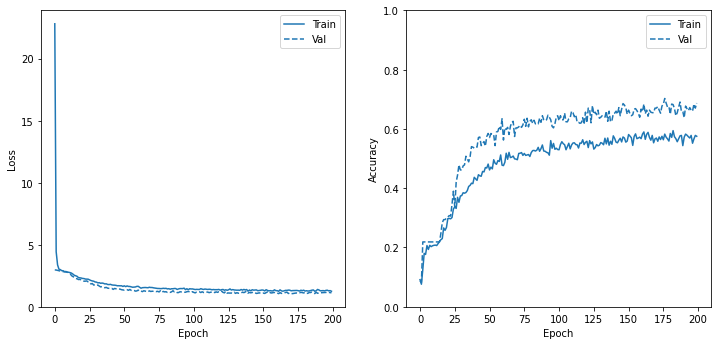

In [41]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [42]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),df_test['delta'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(837, 40)
['id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10001' 'id10004'
 'id10001' 'id10004' 'id10009' 'id10001' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10009' 'id10004' 'id10004' 'id10007' 'id10007' 'id10014'
 'id10007' 'id10007' 'id10004' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10014' 'id10007' 'id10014' 'id10007' 'id10007'
 'id10014' 'id10007' 'id10014' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10014' 'id10006' 'id10006'
 'id10004' 'id10014' 'id10006' 'id10014' 'id10006' 'id10006' 'id10006'
 'id10004' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10004' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10004' 'id10006' 'id10014' 'id10004' 'id10004' 'id10001'
 'id10008' 'id10004' 'id10004' 'id10004' 'id10004' 'id10001' 'id10001'
 'id10016' 'id10014' 'id10004' 'id10004' 'id10016' 'id10004' 'id100

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# clip = '/Users/vpapadop/Documents/GitHub/speaker-similarity/vox_dev_wav/wav/id10001/1zcIwhmdeo4/00001.wav'
# tmp = pd.DataFrame()
# tmp[['mfcc', 'delta']] = extract_mfcc(clip,20)
# X_tmp = np.hstack((tmp['mfcc'].to_list(),tmp['delta'].to_list()))
# X_tmp = np.expand_dims(X_tmp, axis=0)
# print(X_tmp.shape)

# y_pred = model.predict(X_tmp)
# print(y_pred)

## Gausian Mixture Model